# Semi Synthetic Experiment 
Semi-synthetic dataset experiment

In [1]:
import sys 
sys.path.append('../..')
sys.path.append('/opt/anaconda3/lib/python3.7/site-packages')

import cox
from cox.store import Store
from cox.utils import Parameters
from cox.readers import CollectionReader
import torch as ch
from torch import Tensor
import torch.linalg as LA
from torch.utils.data import DataLoader
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import math
from sklearn.metrics import r2_score
import os
import datetime
from sklearn.datasets import load_boston
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D 
import subprocess

from delphi import oracle 
from delphi.stats.linear_regression import TruncatedRegression

# set environment variable so that stores can create output files
# os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

TABLE_NAME = 'logs'
COMMAND = 'RScript'

# commands and arguments
COMMAND = 'Rscript'
PATH2SCRIPT = './truncreg.R'
TMP_FILE = 'tmp.csv'
RESULT_FILE = 'result.csv'

# mean squared error loss
mse_loss = ch.nn.MSELoss()

# Import Dataset into Notebook

In [2]:
columns = ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 
           'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 
           'engine-type', 'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-ratio',
          'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']


In [3]:
dataset = '/Users/patroklos/Desktop/research/pm10.csv'
df = pd.read_csv(dataset)
df.head()

# bunch = load_boston()
# data = np.concatenate([bunch['data'], np.expand_dims(bunch['target'], 1)], axis=1)
# df = pd.DataFrame(data, columns=bunch['feature_names'].tolist() + ['MEDV'])
# df.head()

,pm10_concentration,cars_per_hour,temperature_at_2m,wind_speed,temperature_diff_2m_25m,wind_direction,hour_of_day,day
0,3.66356,7.74414,-4.4,4.2,0.0,18.0,19,116
1,3.04452,8.03398,-5.7,4.8,-0.3,69.1,9,506
2,3.71357,4.70048,-13.5,4.3,0.2,80.0,3,95
3,2.94444,7.52510,1.4,3.0,0.1,177.0,22,161
4,4.06044,7.76260,4.1,5.6,1.1,287.0,7,80


In [4]:
(df == '?').sum()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


pm10_concentration         0
cars_per_hour              0
temperature_at_2m          0
wind_speed                 0
temperature_diff_2m_25m    0
wind_direction             0
hour_of_day                0
day                        0
dtype: int64

In [283]:
df['peak-rpm']

0      5000
1      5000
2      5000
3      5500
4      5500
       ... 
200    5400
201    5300
202    5500
203    4800
204    5400
Name: peak-rpm, Length: 205, dtype: object

In [137]:
df['price'].replace('?', df['price'][df['price'] != '?'].astype(float).mean(), inplace=True)


In [162]:
df['bore'].replace('?', df['bore'][df['bore'] != '?'].astype(float).mean(), inplace=True)

In [163]:
df['peak-rpm'].replace('?', df['peak-rpm'][df['peak-rpm'] != '?'].astype(float).mean(), inplace=True)


In [164]:
df['stroke'].replace('?', df['stroke'][df['stroke'] != '?'].astype(float).mean(), inplace=True)


In [165]:
df['horsepower'].replace('?', int(df['horsepower'][df['horsepower'] != '?'].astype(int).mean()), inplace=True)


In [166]:
doors = { 
    'two': 0, 
    'four': 1,
}

df['num-of-doors'].replace(doors, inplace=True)

TypeError: Cannot compare types 'ndarray(dtype=int64)' and 'str'

In [167]:
df['num-of-doors'].mode()

0    1
dtype: int64

In [168]:
df['num-of-doors'].replace('?', int(df['num-of-doors'][df['num-of-doors'] != '?'].astype(int).mode()), inplace=True)


In [169]:
df['normalized-losses'].replace('?', df['normalized-losses'][df['normalized-losses'] != '?'].astype(float).mean(), inplace=True)
# df['Solar.R'].replace(np.nan, df['Solar.R'].dropna().mean(), inplace=True)

In [170]:
df['normalized-losses']

0      122
1      122
2      122
3      164
4      164
      ... 
200     95
201     95
202     95
203     95
204     95
Name: normalized-losses, Length: 205, dtype: object

The first thing that we want to do is check if there are any columns with NaN values in the dataframe.

In [120]:
nan_values = df.isna()
nan_columns = nan_values.any()

columns_with_nan = df.columns[nan_columns].tolist()
print(columns_with_nan)

[]


We see that there are two columsn with NaN values in them. We will fill the values of these columns with the mean of the rest of the data for the feature.

In [111]:
if len(columns_with_nan) > 0: 
    df['Ozone'].replace(np.nan, df['Ozone'].dropna().mean(), inplace=True)
    df['Solar.R'].replace(np.nan, df['Solar.R'].dropna().mean(), inplace=True)
# drop Unnamed: 0 column if in dataframe
if 'Unnamed: 0' in df.columns:
    df.drop(columns='Unnamed: 0', inplace=True)

# Data Exploration

In [173]:
df = df.apply(pd.to_numeric)
df

ValueError: ('Unable to parse string "alfa-romero" at position 0', 'occurred at index make')

In [6]:
# df['horsepower'] = pd.to_numeric(df['horsepower'], errors='coerce')
# df['price'] = pd.to_numeric(df['price'], errors='coerce')
# df.dropna(subset=['horsepower', 'price'], inplace=True)

X, y = Tensor(df[['cars_per_hour', 'wind_speed']].to_numpy()), Tensor(df['pm10_concentration'].to_numpy()[...,None])



In [5]:
# columns = ['ZN', 'CHAS', 'NOX', 'RM', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
# X, y = df[['ZN', 'CHAS', 'NOX', 'RM', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']].to_numpy(), df['MEDV'].to_numpy().reshape(-1, 1)

X, y = df['horsepower'].to_numpy()[...,None], df['price'].to_numpy().reshape(-1, 1)

# X, y = df[['X2 house age', 'X4 number of convenience stores', 'X3 distance to the nearest MRT station', 'X6 longitude']].to_numpy(), df['Y house price of unit area'][...,None]

X, y = Tensor(X), Tensor(y)

KeyError: 'horsepower'

In [7]:
from scipy.stats import pearsonr

cols = ['horsepower', 'engine-size', 'peak-rpm', 'length', 'width', 'height']
#preprocess the data
for col in cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df.dropna(subset=['price', 'horsepower'], inplace=True)

for col in cols:
    print(col, pearsonr(df[col], df['price']))

KeyError: 'horsepower'

In [377]:
model_cols = ['horsepower', 'engine-size', 'length', 'width']
X = Tensor(np.column_stack(tuple(df[col] for col in model_cols)))
y = Tensor(df['price'].to_numpy()[...,None])

(array([ 8.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,
         0.,  4.,  0.,  0.,  0.,  0.,  6.,  0.,  0.,  0.,  6.,  0.,  0.,
        13.,  0.,  0., 14.,  0.,  9.,  0.,  0., 13.,  0.,  5.,  0., 14.,
        14.,  0., 11.,  8.,  0.,  6.,  7.,  4., 10., 15.,  0., 17., 23.,
        12., 12., 13., 13., 19., 16., 11.,  6., 12.,  4.,  9., 10., 13.,
         9.,  4.,  8.,  8.,  3., 11.,  7.,  7.,  4.,  8.,  6.,  3.,  5.,
         6.,  4.,  7.,  2.,  3.,  6.,  4.,  3.,  0.,  3.,  4.,  1.,  5.,
         0.,  1.,  1.,  1.,  1.,  2.,  1.,  0.,  2.]),
 array([0.69315   , 0.7401548 , 0.78715956, 0.8341644 , 0.8811692 ,
        0.92817396, 0.9751788 , 1.0221835 , 1.0691884 , 1.1161932 ,
        1.163198  , 1.2102028 , 1.2572076 , 1.3042123 , 1.3512172 ,
        1.398222  , 1.4452268 , 1.4922316 , 1.5392364 , 1.5862412 ,
        1.633246  , 1.6802508 , 1.7272556 , 1.7742604 , 1.8212652 ,
        1.86827   , 1.9152747 , 1.9622796 , 2.0092845 , 2.0562892 ,
        2.103294  , 2.1502

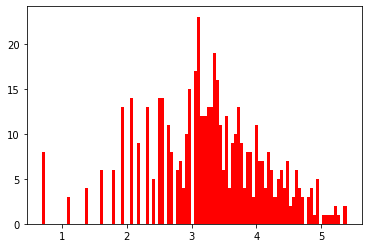

In [8]:
plt.hist(y.T, bins=100, color='red')

# Create Correlation Matrix
Create a correlation matrix to see which features are correlated to air quality data collection.

In [299]:
df = df[columns]

In [8]:
corr_matrix = df.corr()
corr_matrix

,ZN,CHAS,NOX,RM,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
ZN,1.000000,-0.042697,-0.516604,0.311991,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995,0.360445
CHAS,-0.042697,1.000000,0.091203,0.091251,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929,0.175260
NOX,-0.516604,0.091203,1.000000,-0.302188,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879,-0.427321
RM,0.311991,0.091251,-0.302188,1.000000,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808,0.695360
DIS,0.664408,-0.099176,-0.769230,0.205246,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996,0.249929
RAD,-0.311948,-0.007368,0.611441,-0.209847,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676,-0.381626
TAX,-0.314563,-0.035587,0.668023,-0.292048,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993,-0.468536
PTRATIO,-0.391679,-0.121515,0.188933,-0.355501,-0.232471,0.464741,0.460853,1.000000,-0.177383,0.374044,-0.507787
B,0.175520,0.048788,-0.380051,0.128069,0.291512,-0.444413,-0.441808,-0.177383,1.000000,-0.366087,0.333461
LSTAT,-0.412995,-0.053929,0.590879,-0.613808,-0.496996,0.488676,0.543993,0.374044,-0.366087,1.000000,-0.737663


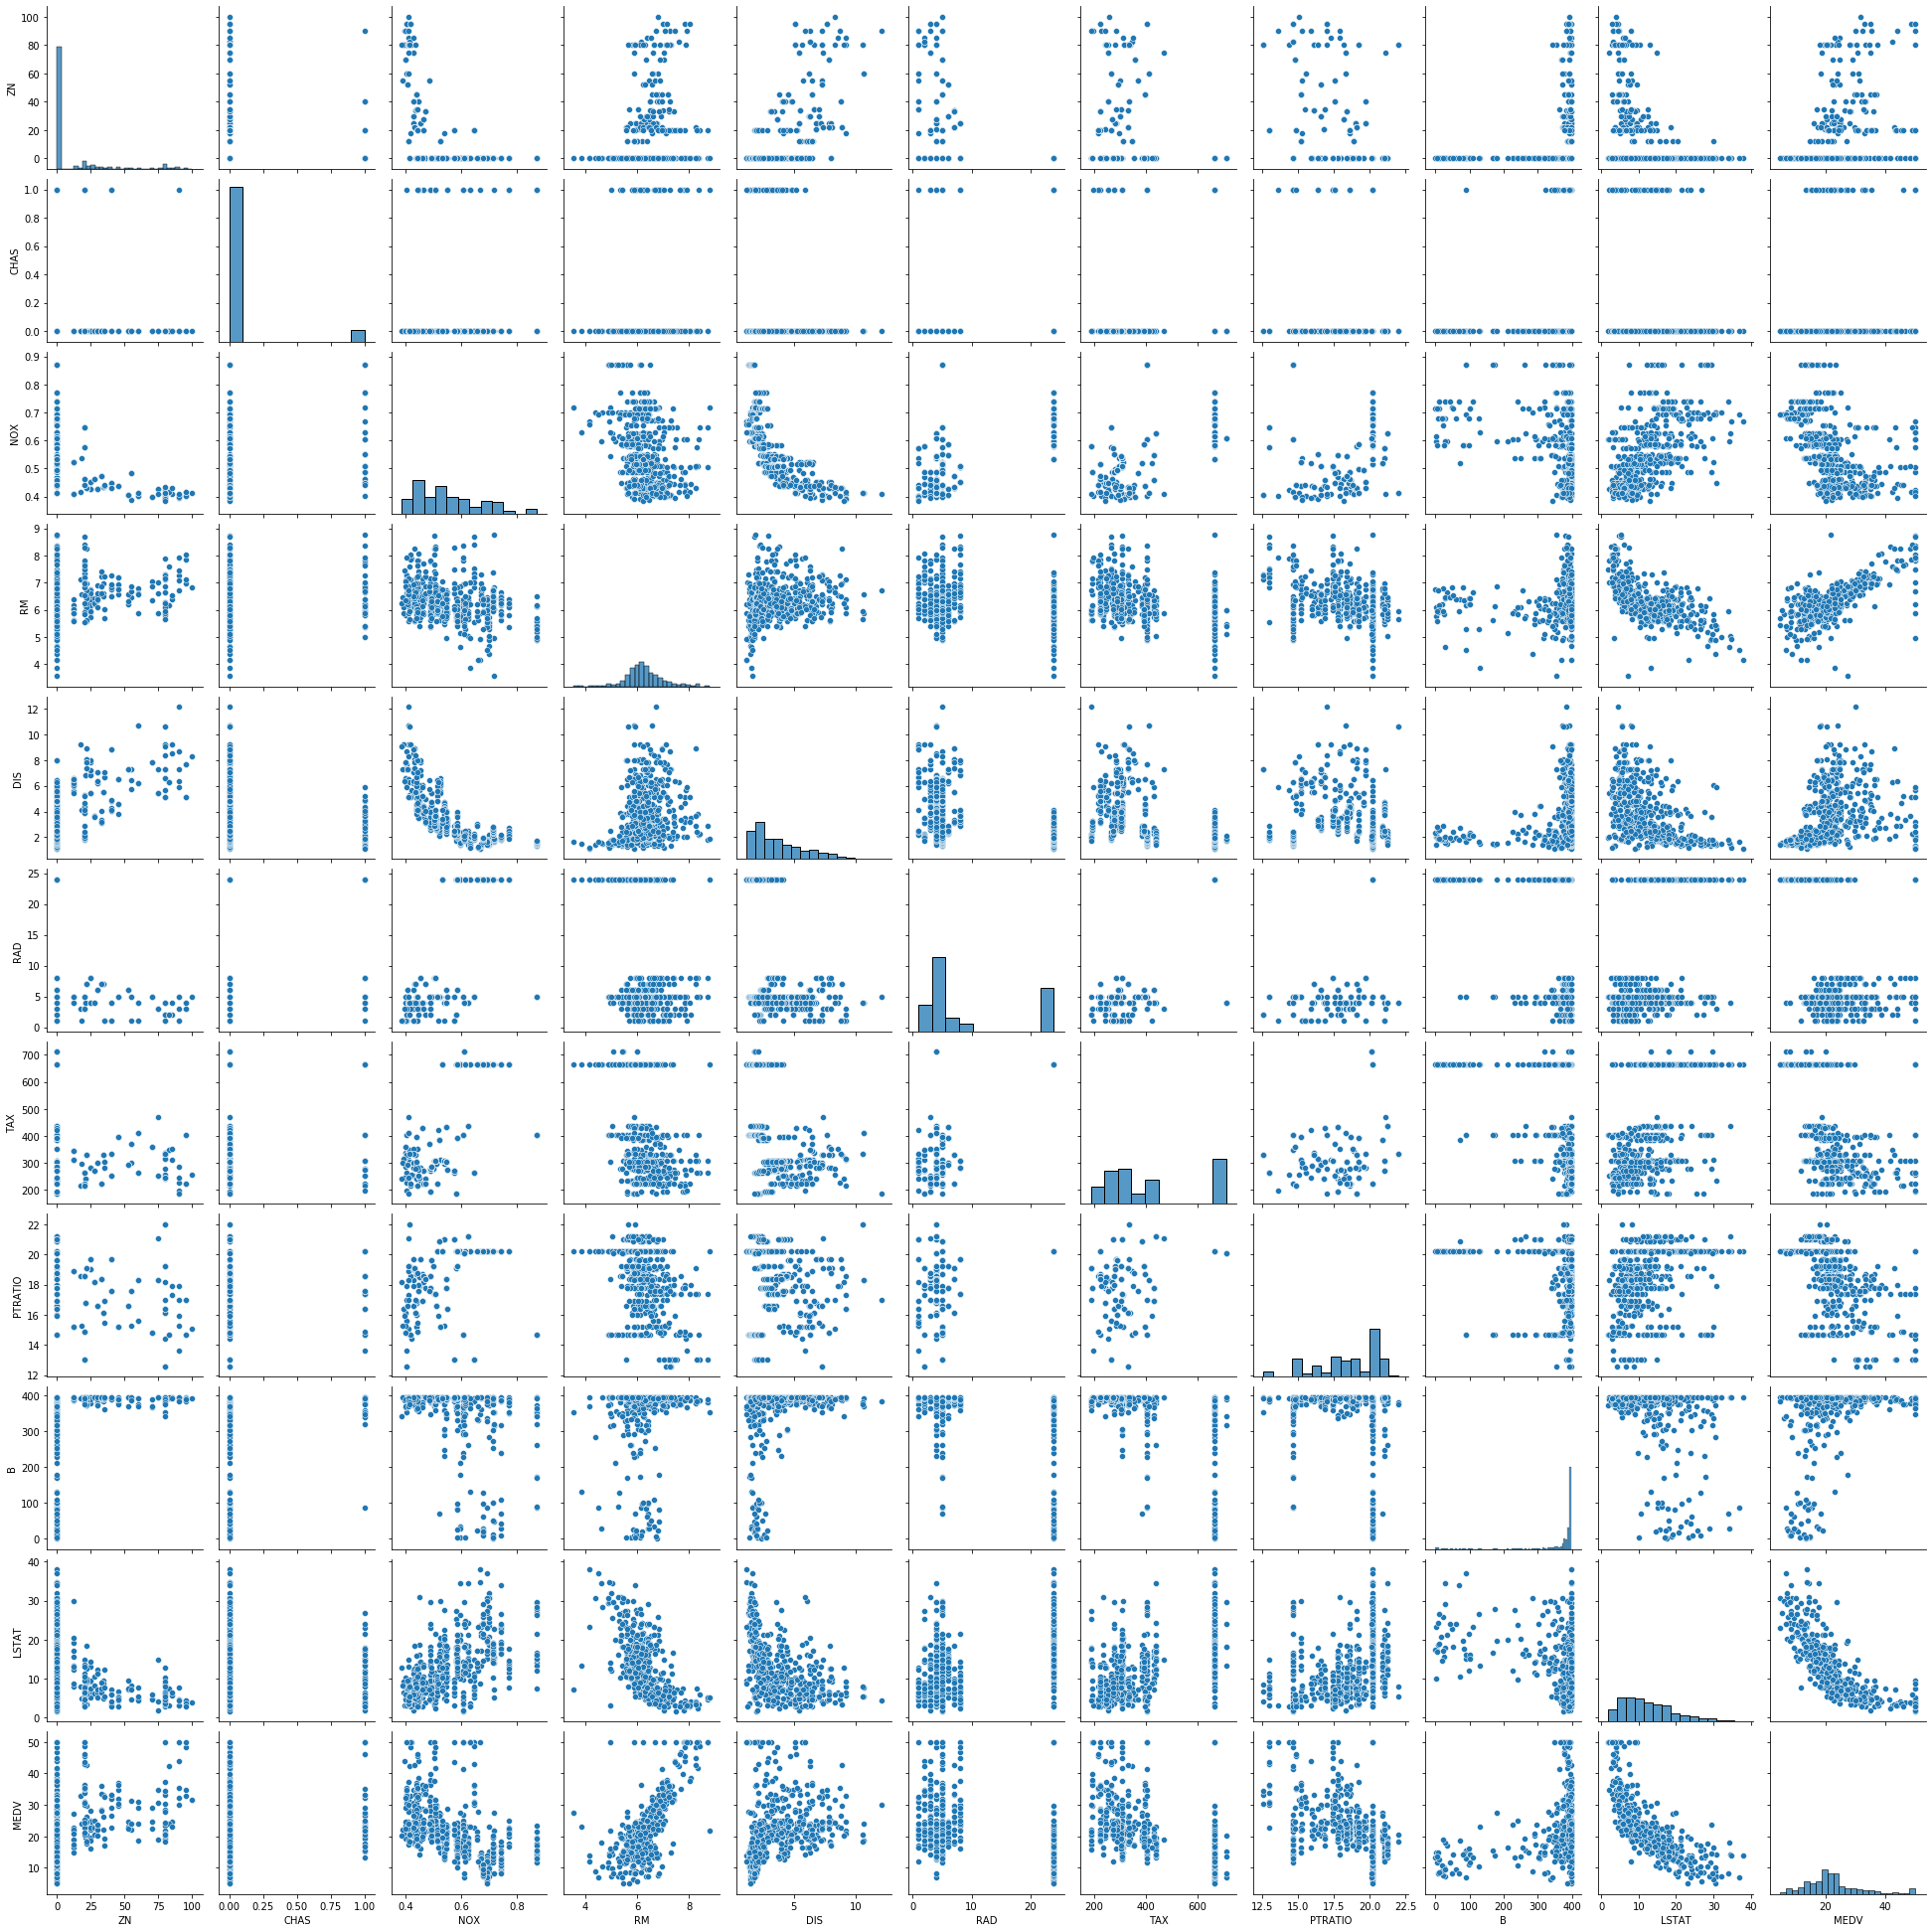

In [11]:
sns.pairplot(df)

First, let's take see if there is a linear relationship between solar.R and Ozone.

In [9]:
data = ch.linspace(0, 1500, 100).reshape(100, 1)

gt_ols = LinearRegression()
gt_ols.fit(X, y)
score = gt_ols.score(X, y)
print("r^2: ", score)
gt_var = (y - gt_ols.predict(X)).var(0)
print('ground-truth variance: ', float(gt_var))

r^2:  0.1728636862809666
ground-truth variance:  0.6504841446876526


In [8]:
X.size()

torch.Size([500, 2, 1])

In [385]:
gt_var

tensor([11673852.])

In [373]:
X.shape, y.shape

((199, 4), (199, 1))

ValueError: x and y must be the same size

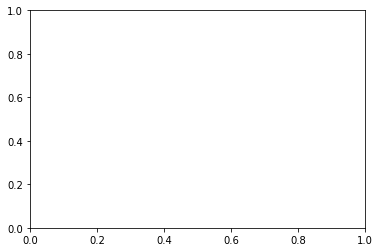

In [10]:
plt.scatter(X, y, color='grey')
data = ch.linspace(50, 300, 100)[...,None]
plt.plot(data, gt_ols.predict(data), color='red')

# Now we standardize our empirical data and generate new ols estimates

In [11]:
# random = ch.randn(X.shape[1], 2)
random = ch.eye(X.shape[1], 2)
x_transform = X@random
w_transform = Tensor(gt_ols.coef_)@random

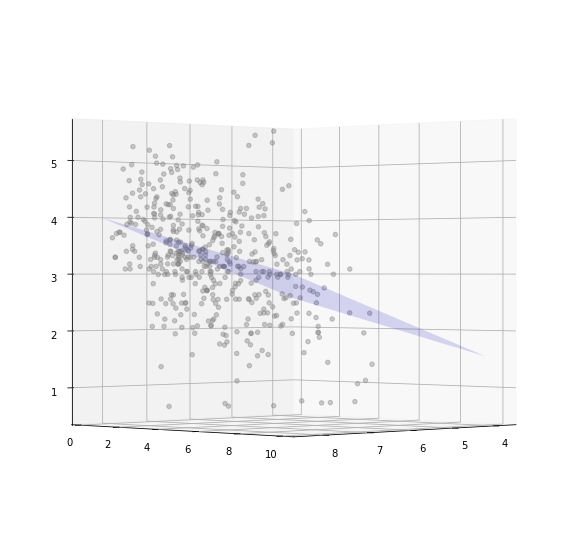

In [12]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')

# X_ = np.arange(-50, 50, 0.25)
# Y = np.arange(-50, 50, 0.25)

x_max, x_min = x_transform.max(0)[0], x_transform.min(0)[0]
X_ = np.arange(x_min[0], x_max[0], .1)
Y = np.arange(x_min[1], x_max[1], .1)
X_, Y = np.meshgrid(X_, Y) 

# pred = Tensor([])
# for i in range(X_.shape[0]): 
#     input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
#     pred = ch.cat([pred, input_@w_transform.T + ols.intercept_], 1)
# ax.plot_surface(X_, Y, pred.numpy().T, alpha=.15, color='green')

actual = Tensor([])
for i in range(X_.shape[0]): 
    input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
    actual = ch.cat([actual, input_@w_transform.T + gt_ols.intercept_], 1)
ax.plot_surface(X_, Y, actual.numpy().T, alpha=.15, color='blue')


# emp = Tensor([])
# for i in range(X_.shape[0]): 
#     input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
#     emp = ch.cat([emp, Tensor(ols.predict(input_))], 1)
# ax.plot_surface(X_, Y, emp.numpy().T, alpha=.15, color='red')

ax.scatter3D(x_transform[:,0], x_transform[:,1], y, color='grey', label='S', alpha=.4)
# ax.scatter3D(x_trunc[:,0], x_trunc[:,1], y_trunc, color='grey', label='S', alpha=.4)
ax.view_init(0, 45)

In [26]:
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler

x = StandardScaler().fit_transform(X.T)

pca = PCA(n_components = 2)
pca.fit(x)


PCA(n_components=2)

In [13]:
principal_components = pca.components_.T

In [14]:
pca_ols = LinearRegression()
pca_ols.fit(principal_components, y)

LinearRegression()

NameError: name 'principal_components' is not defined

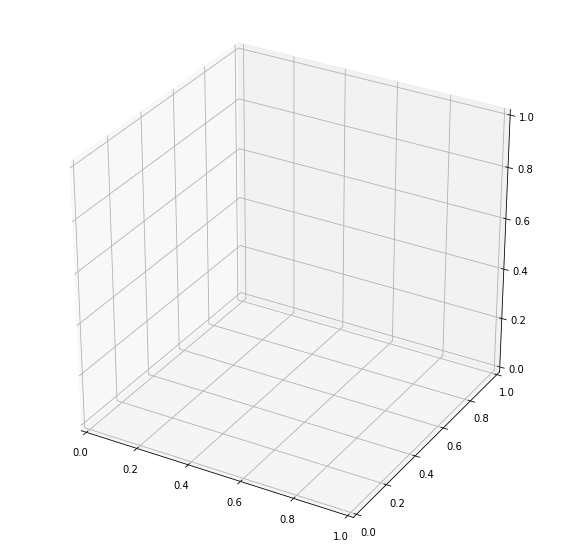

In [13]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')

x_max, x_min = Tensor(principal_components.max(0)), Tensor(principal_components.min(0))
X_ = np.arange(x_min[0], x_max[0], 0.01)
Y = np.arange(x_min[1], x_max[1], 0.01)
X_, Y = np.meshgrid(X_, Y) 

# pred = Tensor([])
# for i in range(X_.shape[0]): 
#     input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
#     pred = ch.cat([pred, input_@w_transform.T + ols.intercept_], 1)
# ax.plot_surface(X_, Y, pred.numpy().T, alpha=.15, color='green')

actual = Tensor([])
for i in range(X_.shape[0]): 
    input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
    actual = ch.cat([actual, Tensor(pca_ols.predict(input_))], 1)
ax.plot_surface(X_, Y, actual.numpy().T, alpha=.15, color='blue')


# emp = Tensor([])
# for i in range(X_.shape[0]): 
#     input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
#     emp = ch.cat([emp, Tensor(ols.predict(input_))], 1)
# ax.plot_surface(X_, Y, emp.numpy().T, alpha=.15, color='red')

ax.scatter3D(principal_components[:,0], principal_components[:,1], y, color='grey', label='S', alpha=.4)
ax.view_init(0, 145)

# Truncate Dataset

In [97]:
phi = oracle.Left(3.25)
indices = phi(y).flatten().nonzero(as_tuple=False).flatten()
x_trunc, y_trunc = X[indices], y[indices]
alpha = x_trunc.size(0) / X.size(0)
print("alpha: ", alpha)

alpha:  0.532


In [98]:
trunc_ols = LinearRegression()
trunc_ols.fit(x_trunc, y_trunc) 
score = trunc_ols.score(X, y)
print("r^2: ", score)
emp_var = (y_trunc - trunc_ols.predict(x_trunc)).var(0)
print('empirical variance: ', float(emp_var))

r^2:  -0.3894665234800925
empirical variance:  0.26433953642845154


In [99]:
x_trunc_transform = x_transform[indices]
w = Tensor(trunc_ols.coef_)@random

# Truncate Regression


# Data Preprocessing
We will now use our algorithms to try to correct for this bias.

In [100]:
data = ch.linspace(0, 1.5, 100).reshape(-1, 1)

# scale wind by actual noise variance
y_trunc_mu = y_trunc.mean(0)
y_trunc_scaled = (y_trunc - y_trunc_mu) / ch.sqrt(gt_var)
y_scaled = (y - y_trunc_mu) / ch.sqrt(gt_var)

beta = LA.norm(x_trunc, dim=-1, ord=float('inf')).max()*math.sqrt(X.size(1))
x_trunc_norm = x_trunc / beta
x_norm = X / beta

scaled_ols = LinearRegression()
scaled_ols.fit(x_norm, y_scaled)

trunc_scaled_ols = LinearRegression()
trunc_scaled_ols.fit(x_trunc_norm, y_trunc_scaled)

LinearRegression()

In [101]:
data = ch.linspace(0, 1.5, 100).reshape(-1, 1)

# scale wind by actual noise variance
y_trunc_mu = y_trunc.mean(0)
y_trunc_emp_scaled = (y_trunc - y_trunc_mu) / ch.sqrt(emp_var)
y_emp_scaled = (y - y_trunc_mu) / ch.sqrt(emp_var)

beta = LA.norm(x_trunc, dim=-1, ord=float('inf')).max()*math.sqrt(X.size(1))
x_trunc_norm = x_trunc / beta
x_norm = X / beta

emp_scaled_ols = LinearRegression()
emp_scaled_ols.fit(x_norm, y_emp_scaled)

trunc_emp_scaled_ols = LinearRegression()
trunc_emp_scaled_ols.fit(x_trunc_norm, y_trunc_emp_scaled)

LinearRegression()

ValueError: x and y must be the same size

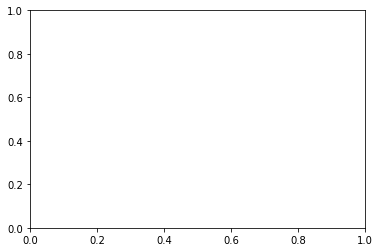

In [19]:
plt.scatter(x_trunc_norm, y_trunc_emp_scaled, color='grey')
data = ch.linspace(0, 1, 100)[...,None]
plt.plot(data, trunc_emp_scaled_ols.predict(data), color='red')
plt.plot(data, emp_scaled_ols.predict(data), color='blue')

In [102]:
w_trunc_transform = Tensor(trunc_ols.coef_)@random

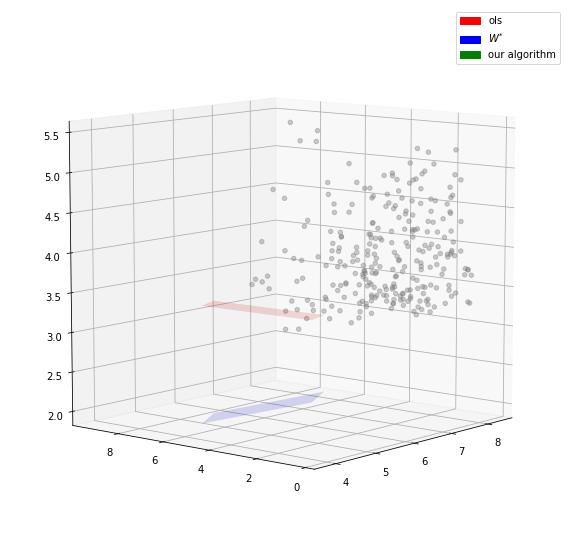

In [103]:
import matplotlib.patches as mpatches

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')


x_max, x_min = x_transform.max(0)[0], x_transform.min(0)[0]
X_ = np.arange(x_min[0], x_max[0]/2, .1)
Y = np.arange(x_min[1], x_max[1]/2, .1)
X_, Y = np.meshgrid(X_, Y) 

with ch.no_grad():
    emp = Tensor([])
    for i in range(X_.shape[0]): 
        input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
        emp = ch.cat([emp, input_@w.T + trunc_ols.intercept_], 1)
    ax.plot_surface(X_, Y, emp.numpy().T, alpha=.15, color='red')
    
    actual = Tensor([])
    for i in range(X_.shape[0]): 
        input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
        actual = ch.cat([actual, input_@w_transform.T + gt_ols.intercept_], 1)
    ax.plot_surface(X_, Y, actual.numpy().T, alpha=.15, color='blue')
    
    
#     pred = Tensor([])
#     for i in range(X_.shape[0]): 
#         input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
#         pred = ch.cat([pred, input_@w_transform.T + trunc_ols.intercept_], 1)
#     ax.plot_surface(X_, Y, pred.numpy().T, alpha=.15, color='green')

ax.scatter3D(x_trunc_transform[:,0], x_trunc_transform[:,1], y_trunc, color='grey', label='S', alpha=.4)

    
red_patch = mpatches.Patch(color='red', label='ols')

green_patch = mpatches.Patch(color='green', label='our algorithm')
blue_patch = mpatches.Patch(color='blue', label="$W^{*}$")
plt.legend(handles=[red_patch, blue_patch, green_patch], loc="upper right")
    
ax.view_init(9.0, 220)

Now, we will our truncated regression algorithm with known variance of the truncated regression data.

In [104]:
scaled_phi = oracle.Left((phi.left - y_trunc_mu) / ch.sqrt(gt_var))
known_trunc_reg = TruncatedRegression(phi=scaled_phi, alpha=Tensor([alpha]), lr=1e-1, unknown=False, bs=10, n=100, tol=1e-2, steps=2500, val=int(.1*y_trunc.size(0)))
known_trunc_reg.fit(x_trunc_norm, y_trunc_scaled)

weight bounds:  Bounds(lower=tensor([-22.5783, -24.7671]), upper=tensor([26.6098, 24.4210]))
bias bounds:  Bounds(lower=-25.629316329956055, upper=23.55882453918457)
var bounds:  None
Iteration 1 | Score: 0.3279658257961273
Iteration 2 | Score: 0.325654000043869
Iteration 3 | Score: 0.33060795068740845
Iteration 4 | Score: 0.3084285259246826
Iteration 5 | Score: 0.3004656434059143
Iteration 6 | Score: 0.32860150933265686
Iteration 7 | Score: 0.306394100189209
Iteration 8 | Score: 0.3201453387737274
Iteration 9 | Score: 0.3045090138912201
Iteration 10 | Score: 0.34718286991119385
Iteration 11 | Score: 0.30194684863090515
Iteration 12 | Score: 0.3007536232471466
Iteration 13 | Score: 0.3180225193500519
Iteration 14 | Score: 0.3095667362213135
Iteration 15 | Score: 0.3295377194881439
Iteration 16 | Score: 0.28352752327919006
Iteration 17 | Score: 0.3269805312156677
Iteration 18 | Score: 0.2933584451675415
Iteration 19 | Score: 0.3367561101913452
Iteration 20 | Score: 0.33995524048805237
I

Linear(in_features=2, out_features=1, bias=True)

ValueError: x and y must be the same size

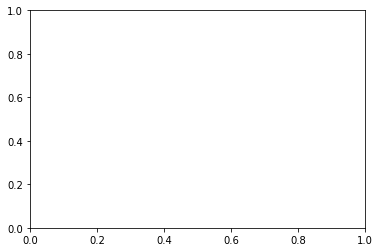

In [23]:
plt.scatter(x_trunc_norm, y_trunc_scaled, color='grey')
data = ch.linspace(0, 1, 100)[...,None]
plt.plot(data, trunc_scaled_ols.predict(data), color='red', label='trunc ols')
plt.plot(data, scaled_ols.predict(data), color='blue', label='ground truth')
with ch.no_grad():
    plt.plot(data, known_trunc_reg(data), color='green', label='known')
    
plt.xlabel('Horshepower')
plt.ylabel('Price')
plt.legend()

In [105]:
known_w, known_w0 = (known_trunc_reg.weight * ch.sqrt(gt_var)) / beta, known_trunc_reg.intercept * ch.sqrt(gt_var) + y_trunc_mu

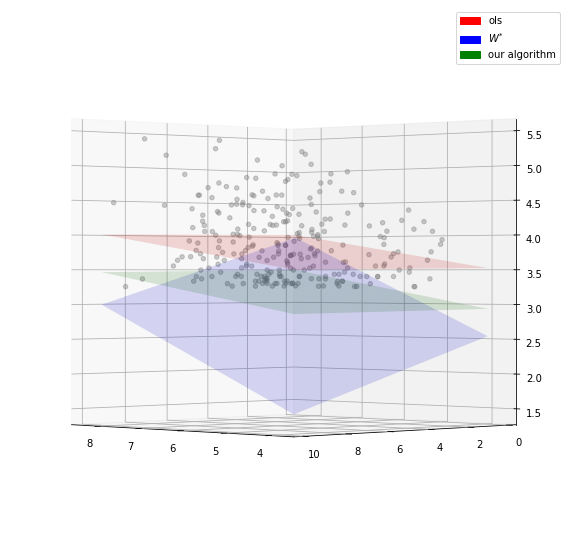

In [106]:
import matplotlib.patches as mpatches

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')


# ax.scatter3D(x_non_trunc[:,0], x_non_trunc[:,1], y_non_trunc, color='red', label='not seen', alpha=.1)


x_max, x_min = x_transform.max(0)[0], x_transform.min(0)[0]
X_ = np.arange(x_min[0], x_max[0], 0.1)
Y = np.arange(x_min[1], x_max[1], 0.1)
X_, Y = np.meshgrid(X_, Y) 

with ch.no_grad():
    emp = Tensor([])
    for i in range(X_.shape[0]): 
        input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
        emp = ch.cat([emp, input_@w.T + trunc_ols.intercept_], 1)
    ax.plot_surface(X_, Y, emp.numpy().T, alpha=.15, color='red')
    
    actual = Tensor([])
    for i in range(X_.shape[0]): 
        input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
        actual = ch.cat([actual, input_@w_transform.T + gt_ols.intercept_], 1)
    ax.plot_surface(X_, Y, actual.numpy().T, alpha=.15, color='blue')
    
    known_w_transform = known_w.T@random
    
    pred = Tensor([])
    for i in range(X_.shape[0]): 
        input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
        pred = ch.cat([pred, input_@known_w_transform.T + known_w0], 1)
    ax.plot_surface(X_, Y, pred.numpy().T, alpha=.15, color='green')

ax.scatter3D(x_trunc_transform[:,0][...,None], x_trunc_transform[:,1][...,None], y_trunc, color='grey', label='S', alpha=.4)

    
red_patch = mpatches.Patch(color='red', label='ols')

green_patch = mpatches.Patch(color='green', label='our algorithm')
blue_patch = mpatches.Patch(color='blue', label="$W^{*}$")
plt.legend(handles=[red_patch, blue_patch, green_patch], loc="upper right")
    
ax.view_init(0.0, 135)

In [107]:
emp_scaled_phi = oracle.Left((phi.left - y_trunc_mu) / ch.sqrt(emp_var))
unknown_trunc_reg = TruncatedRegression(phi=emp_scaled_phi, alpha=Tensor([alpha]), unknown=True, lr=1e-1, step_lr_gamma=.9, bs=100, n=10, tol=1e-1, steps=5000, val=int(.1*y_trunc.size(0)))
unknown_trunc_reg.fit(x_trunc_norm, y_trunc_emp_scaled)

weight bounds:  Bounds(lower=tensor([-31.4178, -34.5377]), upper=tensor([37.7703, 34.6504]))
bias bounds:  Bounds(lower=-36.339717864990234, upper=32.84842300415039)
var bounds:  Bounds(lower=0.529227077960968, upper=3.7398033142089844)
Iteration 1 | Score: 0.25572681427001953
Iteration 2 | Score: 0.28171753883361816
Iteration 3 | Score: 0.253976434469223
Iteration 4 | Score: 0.2878328859806061
Iteration 5 | Score: 0.3079661428928375
Iteration 6 | Score: 0.3387693464756012
Iteration 7 | Score: 0.31726109981536865
Iteration 8 | Score: 0.34002041816711426
Iteration 9 | Score: 0.35931214690208435
Iteration 10 | Score: 0.299274206161499
Iteration 11 | Score: 0.3568130135536194
Iteration 12 | Score: 0.2847192883491516
Iteration 13 | Score: 0.32650667428970337
Iteration 14 | Score: 0.367313027381897
Iteration 15 | Score: 0.27772656083106995
Iteration 16 | Score: 0.3287545144557953
Iteration 17 | Score: 0.30214017629623413
Iteration 18 | Score: 0.301202654838562
Iteration 19 | Score: 0.355563

Iteration 204 | Score: 0.30158403515815735
Iteration 205 | Score: 0.2848191261291504
Iteration 206 | Score: 0.3701847493648529
Iteration 207 | Score: 0.26855888962745667
Iteration 208 | Score: 0.2977510392665863
Iteration 209 | Score: 0.4058733880519867
Iteration 210 | Score: 0.3256962299346924
Iteration 211 | Score: 0.31553593277931213
Iteration 212 | Score: 0.30298885703086853
Iteration 213 | Score: 0.2898261547088623
Iteration 214 | Score: 0.31534263491630554
Iteration 215 | Score: 0.3928617238998413
Iteration 216 | Score: 0.2907491624355316
Iteration 217 | Score: 0.31805795431137085
Iteration 218 | Score: 0.37624549865722656
Iteration 219 | Score: 0.29470181465148926
Iteration 220 | Score: 0.3366410732269287
Iteration 221 | Score: 0.2746341824531555
Iteration 222 | Score: 0.34502604603767395
Iteration 223 | Score: 0.38245514035224915
Iteration 224 | Score: 0.32088351249694824
Iteration 225 | Score: 0.37455278635025024
Iteration 226 | Score: 0.33581316471099854
Iteration 227 | Score

Iteration 405 | Score: 0.2846944332122803
Iteration 406 | Score: 0.3490528166294098
Iteration 407 | Score: 0.34499022364616394
Iteration 408 | Score: 0.2731240391731262
Iteration 409 | Score: 0.3635479509830475
Iteration 410 | Score: 0.3455689549446106
Iteration 411 | Score: 0.32129421830177307
Iteration 412 | Score: 0.3659648895263672
Iteration 413 | Score: 0.27120068669319153
Iteration 414 | Score: 0.3170607089996338
Iteration 415 | Score: 0.34293797612190247
Iteration 416 | Score: 0.32659584283828735
Iteration 417 | Score: 0.2744143605232239
Iteration 418 | Score: 0.2737194299697876
Iteration 419 | Score: 0.366588830947876
Iteration 420 | Score: 0.34821027517318726
Iteration 421 | Score: 0.30338558554649353
Iteration 422 | Score: 0.3316992521286011
Iteration 423 | Score: 0.29659754037857056
Iteration 424 | Score: 0.2912961542606354
Iteration 425 | Score: 0.32357513904571533
Iteration 426 | Score: 0.3165057599544525
Iteration 427 | Score: 0.3508734703063965
Iteration 428 | Score: 0.3

LinearUnknownVariance()

ValueError: x and y must be the same size

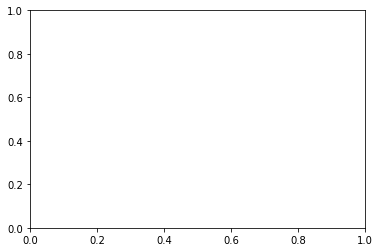

In [108]:
plt.scatter(x_trunc_norm, y_trunc_emp_scaled, color='grey')
data = ch.linspace(0, 1, 100)[...,None]
plt.plot(data, trunc_emp_scaled_ols.predict(data), color='red', label='trunc ols')
plt.plot(data, emp_scaled_ols.predict(data), color='blue', label='ground truth')
with ch.no_grad():
    plt.plot(data, unknown_trunc_reg(data), color='green', label='known')
    
plt.xlabel('Horshepower')
plt.ylabel('Price')
plt.legend()

In [109]:
w_, w0_ = (unknown_trunc_reg.weight * ch.sqrt(emp_var)) / beta, unknown_trunc_reg.intercept * ch.sqrt(emp_var) + y_trunc_mu

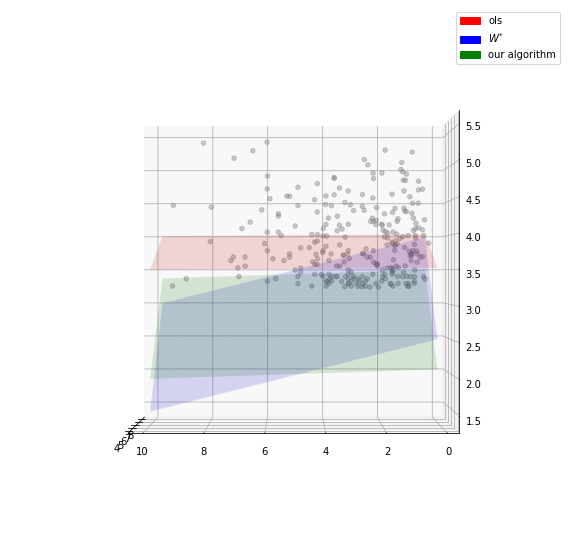

In [112]:
import matplotlib.patches as mpatches

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')


# ax.scatter3D(x_non_trunc[:,0], x_non_trunc[:,1], y_non_trunc, color='red', label='not seen', alpha=.1)


x_max, x_min = x_transform.max(0)[0], x_transform.min(0)[0]
X_ = np.arange(x_min[0], x_max[0], .1)
Y = np.arange(x_min[1], x_max[1], .1)
X_, Y = np.meshgrid(X_, Y) 

with ch.no_grad():
    emp = Tensor([])
    for i in range(X_.shape[0]): 
        input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
        emp = ch.cat([emp, input_@w.T + trunc_ols.intercept_], 1)
    ax.plot_surface(X_, Y, emp.numpy().T, alpha=.15, color='red')
    
    actual = Tensor([])
    for i in range(X_.shape[0]): 
        input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
        actual = ch.cat([actual, input_@w_transform.T + gt_ols.intercept_], 1)
    ax.plot_surface(X_, Y, actual.numpy().T, alpha=.15, color='blue')
    
    unknown_w_transform = w_.T@random
    
    pred = Tensor([])
    for i in range(X_.shape[0]): 
        input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
        pred = ch.cat([pred, input_@unknown_w_transform.T + w0_], 1)
    ax.plot_surface(X_, Y, pred.numpy().T, alpha=.15, color='green')

ax.scatter3D(x_trunc_transform[:,0], x_trunc_transform[:,1], y_trunc, color='grey', label='S', alpha=.4)

    
red_patch = mpatches.Patch(color='red', label='ols')

green_patch = mpatches.Patch(color='green', label='our algorithm')
blue_patch = mpatches.Patch(color='blue', label="$W^{*}$")
plt.legend(handles=[red_patch, blue_patch, green_patch], loc="upper right")
    
ax.view_init(0.0, 180)

In [113]:
unknown_params = ch.cat([w_, w0_]).flatten()
gt_params = Tensor(np.concatenate([gt_ols.coef_.flatten(), gt_ols.intercept_]))
trunc_ols_params = Tensor(np.concatenate([trunc_ols.coef_.flatten(), trunc_ols.intercept_]))
known_params = ch.cat([known_w.flatten(), known_w0.flatten()])

In [114]:
mse_loss(unknown_params, gt_params)

tensor(0.0496)

In [115]:
mse_loss(known_params[None,...], gt_params[None,...])

tensor(0.4272)

In [77]:
known_params, trunc_ols_params

(tensor([ 0.1402, -0.0287,  2.3481]), tensor([ 0.1261, -0.0205,  2.9073]))

In [67]:
mse_loss(trunc_ols_params, gt_params)

tensor(0.8212)

In [68]:
unknown_params, gt_params

(tensor([ 0.3917, -0.0764,  0.5405]), tensor([ 0.3214, -0.1045,  1.3522]))

In [73]:
# spawn subprocess to run truncreg experiment
concat = ch.cat([x_trunc, y_trunc], dim=1).numpy()
"""
DATA FORMAT:
    -First n-1 columns are independent variables
    -nth column is dependent variable
"""
concat_df = pd.DataFrame(concat)
concat_df.to_csv(args.out_dir + '/' + TMP_FILE) # save data to csv
"""
Arguments
- c - truncation point (float)
- dir - left or right -> type of truncation (str)
"""
cmd = [COMMAND, PATH2SCRIPT] + [str(phi.left), str(x_trunc.size(1)), 'left', args.out_dir]

# check_output will run the command and store the result
st = datetime.datetime.now()
result = subprocess.check_output(cmd, universal_newlines=True)
trunc_res = Tensor(pd.read_csv(args.out_dir + '/' + RESULT_FILE)['x'].to_numpy())
trunc_reg_params = ch.cat([trunc_res[1:-1].flatten(), trunc_res[0][None,...]])

trunc_reg_pred = X@trunc_reg_params[:-1] + trunc_reg_params[-1]

In [74]:
(Tensor(gt_ols.coef_) - trunc_reg_params[:-1]).sum()

tensor(-0.0815)

In [75]:
gt_ols.coef_, trunc_reg_params[:-1]

(array([[ 0.32144794, -0.10451495]], dtype=float32),
 tensor([ 0.3479, -0.0495]))

In [76]:
trunc_reg_params[-1], gt_ols.intercept_

(tensor(0.7911), array([1.3522004], dtype=float32))

In [77]:
trunc_ols.intercept_

array([2.90729], dtype=float32)

# Set up Experiment
For storing the experiment's hyperparameters, we use [cox](https://github.com/MadryLab/cox), MadryLab's light-weight experimental design and analysis framework. 

In [119]:
args = Parameters({
    "bs": 100,
    "trials": 10,
    "steps": 1500,
    "out_dir": '/Users/patroklos/regression', 
    "table_name": 'results', 
    'tol': 1e-1,
    'n': 100,
    'lr': 1e-1,
    'step_lr': 100, 
    'step_lr_gamma': .9,
})
EXP = 'PM10BatchSize100'
mse_loss = ch.nn.MSELoss()

# Create Store for Experiment Results

In [120]:
def run_trial(kwargs, X, y):
    """
    Runs a trial of a truncated regression experiment. Runs a maximum 
    of three trials of an experiment. The experiment terminates when either 
    the norm of teh score is less than 3e-1, or when three trials is up. After 
    three trials it returns the best truncated regression experiment.
    :param kwargs: keyword arguments for experiment 
    :param X: independent variable
    :param y: dependent variable
    :return: truncated regression experiment and time that experiment took
    """
    st = datetime.datetime.now()        
    # run procedure until get reasonable score
    attempt, score, best_trunc_reg = 0, None, None
    while (score is None or score.norm() > 3e-1) and attempt < 3:
        trunc_reg = TruncatedRegression(**kwargs)
        trunc_reg.fit(X, y)
        grad = trunc_reg.score()
        if score is None or grad.norm() < score.norm(): 
            score, best_trunc_reg = grad, trunc_reg
        attempt += 1
    total_time = int((datetime.datetime.now() - st).total_seconds())
    return best_trunc_reg, total_time  

# Run Procedure

In [121]:
# ground_truth parameters
gt = LinearRegression() 
gt.fit(X, y)
gt_params = Tensor(np.concatenate([gt.coef_.flatten() ,gt.intercept_]))
gt_var = Tensor(np.var(gt.predict(X) - y.numpy(), 0))

C = [1, 1.5, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 4.0]
for i in range(args.trials):
    # create store
    store = Store(args.out_dir + '/' + EXP)
    store.add_table(TABLE_NAME, { 
        'known_r2': float,
        'known_param_mse': float,
        'known_time': int,
        'unknown_param_mse': float,
        'unknown_var_l1': float,
        'unknown_r2': float,
        'unknown_time': int,
        'ols_r2': float, 
        'ols_param_mse': float,
        'ols_var_l1': float,
        'trunc_reg_param_mse': float, 
        'trunc_reg_var_l1': float,
        'trunc_reg_r2': float,
        'trunc_reg_time': int,
        'alpha': float, 
        'c': float, 
        'num_samples': int,
    })
    
    for c in C: 
        # truncate
        phi = oracle.Left(c)
        indices = phi(y).eq(1).flatten()
        x_trunc, y_trunc = X[indices], y[indices]
        # add survival probability to hyperparameters
        alpha = Tensor([x_trunc.size(0) / X.size(0)])
        
        y_trunc_mu = y_trunc.mean(0)
        
        # empirical linear regression
        ols = LinearRegression() 
        ols.fit(x_trunc, y_trunc)
        emp_noise_var = ch.var(Tensor(ols.predict(x_trunc)) - y_trunc, dim=0)[...,None]
        ols_params = ch.cat([Tensor(ols.coef_).T, Tensor(ols.intercept_)[..., None]]).flatten()

        # ols results
        store[TABLE_NAME].update_row({
            'ols_r2': r2_score(y.flatten(), ols.predict(X).flatten()), 
            'ols_var_l1': ch.abs(emp_noise_var - gt_var),
            'ols_param_mse': mse_loss(ols_params, gt_params),
        })
        val = int(.1*x_trunc.size(0))
        
        beta = LA.norm(x_trunc, dim=-1, ord=float('inf')).max()
        x_trunc_norm = x_trunc / beta
        
        # scale by the known noise variance 
        y_trunc_scaled = (y_trunc - y_trunc_mu) / ch.sqrt(gt_var)
        phi_scaled = oracle.Left((phi.left - y_trunc_mu) / ch.sqrt(gt_var))
        
        # standardize noised by actual noise variance
        known_kwargs = { 
            'phi': phi_scaled, 
            'alpha': alpha, 
            'bias': args.bias, 
            'unknown': False, 
            'bs': args.bs, 
            'n': args.n, 
            'tol': args.tol, 
            'steps': args.steps, 
            'step_lr': args.step_lr, 
            'step_lr_gamma': args.step_lr_gamma,
            'val': val
        }
        
        # truncated linear regression with known noise variance using empirical noise variance
        known_trunc_reg, total_time = run_trial(known_kwargs, x_trunc_norm, y_trunc_scaled) 
        
        w, w0 = (known_trunc_reg.weight * ch.sqrt(gt_var)) / beta, known_trunc_reg.intercept * ch.sqrt(gt_var) + y_trunc_mu 
        known_params = ch.cat([w.flatten(), w0])
        # known results
        store[TABLE_NAME].update_row({
            'known_r2': r2_score(y.flatten(), X@w + w0), 
            'known_param_mse': mse_loss(known_params, gt_params),
            'known_time': total_time, 
        })
        
        phi_emp_scaled = oracle.Left((phi.left - y_trunc_mu) / ch.sqrt(emp_noise_var))
        y_trunc_emp_scaled = (y_trunc - y_trunc_mu) / ch.sqrt(emp_noise_var)
            
        # standardize noised by actual noise variance
        unknown_kwargs = { 
            'phi': phi_emp_scaled, 
            'alpha': alpha, 
            'bias': args.bias, 
            'unknown': True, 
            'bs': args.bs, 
            'n': args.n, 
            'tol': args.tol, 
            'steps': args.steps, 
            'step_lr': args.step_lr, 
            'step_lr_gamma': args.step_lr_gamma,
            'val': val
        }
        
        # truncated linear regression with unknown noise variance using empirical noise variance
        trunc_reg, total_time = run_trial(unknown_kwargs, x_trunc_norm, y_trunc_emp_scaled)  
        
        w, w0 = (trunc_reg.weight * ch.sqrt(emp_noise_var)) / beta, trunc_reg.intercept * ch.sqrt(emp_noise_var) + y_trunc_mu
        unknown_params = ch.cat([w.flatten(), w0.flatten()])
        # known results
        store[TABLE_NAME].update_row({
            'unknown_r2': r2_score(y.flatten(), X@w + w0), 
            'unknown_param_mse': mse_loss(unknown_params, gt_params),
            'unknown_time': total_time, 
            'unknown_var_l1': ch.abs(trunc_reg.variance * emp_noise_var - gt_var)
        })
            
        # spawn subprocess to run truncreg experiment
        concat = ch.cat([x_trunc, y_trunc], dim=1).numpy()
        """
        DATA FORMAT:
            -First n-1 columns are independent variables
            -nth column is dependent variable
        """
        concat_df = pd.DataFrame(concat)
        concat_df.to_csv(args.out_dir + '/' + TMP_FILE) # save data to csv
        """
        Arguments
        - c - truncation point (float)
        - dir - left or right -> type of truncation (str)
        """
        cmd = [COMMAND, PATH2SCRIPT] + [str(c), str(x_trunc.size(1)), 'left', args.out_dir]

        # check_output will run the command and store the result
        st = datetime.datetime.now()
        result = subprocess.check_output(cmd, universal_newlines=True)
        trunc_res = Tensor(pd.read_csv(args.out_dir + '/' + RESULT_FILE)['x'].to_numpy())
        trunc_reg_params = ch.cat([trunc_res[1:-1].flatten(), trunc_res[0][None,...]])

        trunc_reg_pred = X@trunc_reg_params[:-1] + trunc_reg_params[-1]
        
        # truncreg results
        store[TABLE_NAME].update_row({
            'trunc_reg_r2': r2_score(y.flatten(), trunc_reg_pred.flatten()), 
            'trunc_reg_param_mse': mse_loss(trunc_reg_params, gt_params),
            'trunc_reg_var_l1': ch.abs(trunc_res[-1].pow(2)[None,...] - gt_var),
            'trunc_reg_time': int((datetime.datetime.now() - st).total_seconds()), 
            })   

        store[TABLE_NAME].append_row({ 
            'alpha': float(alpha), 
            'c': c,    
            'num_samples': x_trunc.size(0),
        })
            
    # close current store
    store.close()

Logging in: /Users/patroklos/regression/PM10BatchSize100/1d2c8aa2-6ec1-4788-84b6-2aa33090cfb9
weight bounds:  Bounds(lower=tensor([-16.1086, -20.7836]), upper=tensor([23.2398, 18.5648]))
bias bounds:  Bounds(lower=-21.838037490844727, upper=17.51038932800293)
var bounds:  None
Final Score: 0.08534439653158188
weight bounds:  Bounds(lower=tensor([-25.8949, -30.9281]), upper=tensor([33.4535, 28.4203]))
bias bounds:  Bounds(lower=-31.96039390563965, upper=27.388032913208008)
var bounds:  Bounds(lower=0.48753729462623596, upper=1.0070420503616333)
Iteration 1 | Score: 0.1504487544298172
Iteration 2 | Score: 0.15185736119747162
Iteration 3 | Score: 0.14404122531414032
Iteration 4 | Score: 0.1490791141986847
Iteration 5 | Score: 0.14601559937000275
Iteration 6 | Score: 0.1491188257932663
Iteration 7 | Score: 0.14935262501239777
Iteration 8 | Score: 0.14866480231285095
Iteration 9 | Score: 0.14830219745635986
Iteration 10 | Score: 0.1408083587884903
Iteration 11 | Score: 0.13754551112651825
I

Iteration 1 | Score: 0.28960326313972473
Iteration 2 | Score: 0.32235947251319885
Iteration 3 | Score: 0.34349095821380615
Iteration 4 | Score: 0.31550583243370056
Iteration 5 | Score: 0.3308559060096741
Iteration 6 | Score: 0.3236561715602875
Iteration 7 | Score: 0.35153016448020935
Iteration 8 | Score: 0.3485957384109497
Iteration 9 | Score: 0.37195175886154175
Iteration 10 | Score: 0.2870451807975769
Iteration 11 | Score: 0.4020657539367676
Iteration 12 | Score: 0.34492433071136475
Iteration 13 | Score: 0.40808311104774475
Iteration 14 | Score: 0.32943588495254517
Iteration 15 | Score: 0.34319737553596497
weight bounds:  Bounds(lower=tensor([-30.8121, -33.2418]), upper=tensor([34.9265, 32.4968]))
bias bounds:  Bounds(lower=-34.33875274658203, upper=31.39984893798828)
var bounds:  Bounds(lower=0.49438804388046265, upper=2.2699172496795654)
Iteration 1 | Score: 0.10848744213581085
Final Score: 0.09311788529157639
weight bounds:  Bounds(lower=tensor([-23.1562, -24.6653]), upper=tensor(

Iteration 1 | Score: 0.18771378695964813
Iteration 2 | Score: 0.19609381258487701
Iteration 3 | Score: 0.19340617954730988
Iteration 4 | Score: 0.17875809967517853
Iteration 5 | Score: 0.21556685864925385
Iteration 6 | Score: 0.190840482711792
Iteration 7 | Score: 0.18568353354930878
Iteration 8 | Score: 0.19126495718955994
Iteration 9 | Score: 0.19219833612442017
Iteration 10 | Score: 0.21646466851234436
Iteration 11 | Score: 0.17423348128795624
Iteration 12 | Score: 0.20528988540172577
Iteration 13 | Score: 0.19113613665103912
Iteration 14 | Score: 0.18772463500499725
Iteration 15 | Score: 0.18211613595485687
weight bounds:  Bounds(lower=tensor([-20.2135, -22.3825]), upper=tensor([23.6083, 21.4392]))
bias bounds:  Bounds(lower=-23.025604248046875, upper=20.79617691040039)
var bounds:  None
Iteration 1 | Score: 0.25697752833366394
Iteration 2 | Score: 0.2687549889087677
Iteration 3 | Score: 0.26163163781166077
Iteration 4 | Score: 0.27349168062210083
Iteration 5 | Score: 0.27327397465

Iteration 1 | Score: 0.34504038095474243
Iteration 2 | Score: 0.3466182053089142
Iteration 3 | Score: 0.3589571416378021
Iteration 4 | Score: 0.3575601577758789
Iteration 5 | Score: 0.3365994691848755
Iteration 6 | Score: 0.3795447051525116
Iteration 7 | Score: 0.3348638415336609
Iteration 8 | Score: 0.35747987031936646
Iteration 9 | Score: 0.3616621494293213
Iteration 10 | Score: 0.35593920946121216
Iteration 11 | Score: 0.3408887982368469
Iteration 12 | Score: 0.3412783443927765
Iteration 13 | Score: 0.3690076768398285
Iteration 14 | Score: 0.354184091091156
Iteration 15 | Score: 0.37488487362861633
weight bounds:  Bounds(lower=tensor([-25.7385, -30.8680]), upper=tensor([33.6099, 28.4805]))
bias bounds:  Bounds(lower=-32.05230712890625, upper=27.29612159729004)
var bounds:  Bounds(lower=0.48732537031173706, upper=1.0066043138504028)
Iteration 1 | Score: 0.3497852385044098
Iteration 2 | Score: 0.3628529906272888
Iteration 3 | Score: 0.3540775179862976
Iteration 4 | Score: 0.3353086411

weight bounds:  Bounds(lower=tensor([-21.3897, -23.1529]), upper=tensor([24.3489, 22.5857]))
bias bounds:  Bounds(lower=-23.935665130615234, upper=21.802936553955078)
var bounds:  None
Iteration 1 | Score: 0.12511804699897766
Iteration 2 | Score: 0.1281939595937729
Iteration 3 | Score: 0.13543564081192017
Iteration 4 | Score: 0.11952660977840424
Iteration 5 | Score: 0.1335294097661972
Iteration 6 | Score: 0.14829859137535095
Iteration 7 | Score: 0.14857237040996552
Iteration 8 | Score: 0.1577913761138916
Iteration 9 | Score: 0.15114152431488037
Iteration 10 | Score: 0.15126994252204895
Iteration 11 | Score: 0.12736721336841583
Iteration 12 | Score: 0.11780796200037003
Iteration 13 | Score: 0.14736302196979523
Iteration 14 | Score: 0.15970706939697266
Iteration 15 | Score: 0.13978001475334167
weight bounds:  Bounds(lower=tensor([-30.7432, -33.2211]), upper=tensor([34.9954, 32.5175]))
bias bounds:  Bounds(lower=-34.36593246459961, upper=31.372669219970703)
var bounds:  Bounds(lower=0.521

Final Score: 0.05026565119624138
weight bounds:  Bounds(lower=tensor([-16.5999, -20.7796]), upper=tensor([22.9778, 18.7981]))
bias bounds:  Bounds(lower=-21.750648498535156, upper=17.82705307006836)
var bounds:  None
Iteration 1 | Score: 0.1064477413892746
Final Score: 0.08464264869689941
weight bounds:  Bounds(lower=tensor([-26.3373, -31.0154]), upper=tensor([33.2404, 28.5623]))
bias bounds:  Bounds(lower=-31.855579376220703, upper=27.722122192382812)
var bounds:  Bounds(lower=0.49918824434280396, upper=1.061086654663086)
Final Score: 0.08388227224349976
weight bounds:  Bounds(lower=tensor([-17.3501, -20.9648]), upper=tensor([23.0744, 19.4597]))
bias bounds:  Bounds(lower=-21.997055053710938, upper=18.427406311035156)
var bounds:  None
Iteration 1 | Score: 0.23195743560791016
Iteration 2 | Score: 0.21609865128993988
Iteration 3 | Score: 0.24248135089874268
Iteration 4 | Score: 0.24155014753341675
Iteration 5 | Score: 0.23535919189453125
Iteration 6 | Score: 0.22972185909748077
Iterati

Iteration 7 | Score: 0.21437638998031616
Iteration 8 | Score: 0.2683989107608795
Iteration 9 | Score: 0.2449156939983368
Iteration 10 | Score: 0.2997705638408661
Iteration 11 | Score: 0.26471275091171265
Iteration 12 | Score: 0.2816263437271118
Iteration 13 | Score: 0.3090513348579407
Iteration 14 | Score: 0.24449054896831512
Iteration 15 | Score: 0.2544427812099457
weight bounds:  Bounds(lower=tensor([-23.3786, -24.6547]), upper=tensor([25.8095, 24.5334]))
bias bounds:  Bounds(lower=-25.529773712158203, upper=23.658367156982422)
var bounds:  None
Final Score: 0.04930335283279419
weight bounds:  Bounds(lower=tensor([-32.4090, -34.6263]), upper=tensor([36.7791, 34.5618]))
bias bounds:  Bounds(lower=-36.29998016357422, upper=32.888160705566406)
var bounds:  Bounds(lower=0.4914921522140503, upper=3.4731481075286865)
Iteration 1 | Score: 0.16904480755329132
Iteration 2 | Score: 0.20994821190834045
Iteration 3 | Score: 0.11560019850730896
Iteration 4 | Score: 0.18107886612415314
Iteration 5

weight bounds:  Bounds(lower=tensor([-18.8329, -21.9085]), upper=tensor([23.6290, 20.5534]))
bias bounds:  Bounds(lower=-22.75320816040039, upper=19.708683013916016)
var bounds:  None
Final Score: 0.008296720683574677
weight bounds:  Bounds(lower=tensor([-28.2515, -31.9407]), upper=tensor([34.2104, 30.5212]))
bias bounds:  Bounds(lower=-33.165523529052734, upper=29.29636573791504)
var bounds:  Bounds(lower=0.4932606816291809, upper=1.5036144256591797)
Iteration 1 | Score: 0.11600340157747269
Iteration 2 | Score: 0.1293805092573166
Final Score: 0.0970870703458786
weight bounds:  Bounds(lower=tensor([-19.7724, -22.2971]), upper=tensor([24.0494, 21.5247]))
bias bounds:  Bounds(lower=-23.343477249145508, upper=20.478303909301758)
var bounds:  None
Final Score: 0.04283760488033295
weight bounds:  Bounds(lower=tensor([-29.0570, -32.6181]), upper=tensor([34.7647, 31.2037]))
bias bounds:  Bounds(lower=-33.778648376464844, upper=30.04313087463379)
var bounds:  Bounds(lower=0.4853212237358093, u

Iteration 9 | Score: 0.17611196637153625
Iteration 10 | Score: 0.1715722382068634
Iteration 11 | Score: 0.1589101254940033
Iteration 12 | Score: 0.17026600241661072
Iteration 13 | Score: 0.1724472939968109
Iteration 14 | Score: 0.1555112898349762
Iteration 15 | Score: 0.1549653708934784
weight bounds:  Bounds(lower=tensor([-25.8793, -30.8558]), upper=tensor([33.4692, 28.4926]))
bias bounds:  Bounds(lower=-31.974315643310547, upper=27.37411117553711)
var bounds:  Bounds(lower=0.4888843595981598, upper=1.009824514389038)
Iteration 1 | Score: 0.14555591344833374
Iteration 2 | Score: 0.15327231585979462
Iteration 3 | Score: 0.16676367819309235
Iteration 4 | Score: 0.1658332496881485
Iteration 5 | Score: 0.180177703499794
Iteration 6 | Score: 0.14333178102970123
Iteration 7 | Score: 0.156145840883255
Iteration 8 | Score: 0.18357233703136444
Iteration 9 | Score: 0.14668408036231995
Iteration 10 | Score: 0.14282023906707764
Iteration 11 | Score: 0.17997929453849792
Iteration 12 | Score: 0.169

Iteration 9 | Score: 0.37276989221572876
Iteration 10 | Score: 0.3761075437068939
Iteration 11 | Score: 0.36261680722236633
Iteration 12 | Score: 0.35275983810424805
Iteration 13 | Score: 0.3701803386211395
Iteration 14 | Score: 0.35980460047721863
Iteration 15 | Score: 0.37824732065200806
weight bounds:  Bounds(lower=tensor([-20.1190, -22.4411]), upper=tensor([23.7028, 21.3807]))
bias bounds:  Bounds(lower=-23.0560302734375, upper=20.765750885009766)
var bounds:  None
Final Score: 0.07731887698173523
weight bounds:  Bounds(lower=tensor([-29.1255, -32.6617]), upper=tensor([34.6963, 31.1601]))
bias bounds:  Bounds(lower=-33.689395904541016, upper=30.132387161254883)
var bounds:  Bounds(lower=0.5047863125801086, upper=1.8238608837127686)
Final Score: 0.08190460503101349
weight bounds:  Bounds(lower=tensor([-21.4228, -23.1422]), upper=tensor([24.3158, 22.5964]))
bias bounds:  Bounds(lower=-23.890365600585938, upper=21.848236083984375)
var bounds:  None
Final Score: 0.08197731524705887
wei

Iteration 10 | Score: 0.10593195259571075
Iteration 11 | Score: 0.13938501477241516
Iteration 12 | Score: 0.11291993409395218
Iteration 13 | Score: 0.11065804958343506
Iteration 14 | Score: 0.11386137455701828
Iteration 15 | Score: 0.10078204423189163
weight bounds:  Bounds(lower=tensor([-17.3682, -20.9348]), upper=tensor([23.0563, 19.4897]))
bias bounds:  Bounds(lower=-22.026296615600586, upper=18.398164749145508)
var bounds:  None
Iteration 1 | Score: 0.15713511407375336
Iteration 2 | Score: 0.1976483315229416
Iteration 3 | Score: 0.18378613889217377
Iteration 4 | Score: 0.17869438230991364
Iteration 5 | Score: 0.17501051723957062
Iteration 6 | Score: 0.15256254374980927
Iteration 7 | Score: 0.16470299661159515
Iteration 8 | Score: 0.20379802584648132
Iteration 9 | Score: 0.16061338782310486
Iteration 10 | Score: 0.15752877295017242
Iteration 11 | Score: 0.1684817373752594
Iteration 12 | Score: 0.14483018219470978
Iteration 13 | Score: 0.15214034914970398
Iteration 14 | Score: 0.1489

Iteration 10 | Score: 0.24172981083393097
Iteration 11 | Score: 0.2682899534702301
Iteration 12 | Score: 0.28075671195983887
Iteration 13 | Score: 0.2842087149620056
Iteration 14 | Score: 0.25874435901641846
Iteration 15 | Score: 0.2510092556476593
weight bounds:  Bounds(lower=tensor([-30.9917, -32.0597]), upper=tensor([33.2221, 32.1541]))
bias bounds:  Bounds(lower=-33.037288665771484, upper=31.176542282104492)
var bounds:  None
Iteration 1 | Score: 0.31244957447052
Iteration 2 | Score: 0.2589692771434784
Iteration 3 | Score: 0.2717640995979309
Iteration 4 | Score: 0.32994163036346436
Iteration 5 | Score: 0.2583172023296356
Iteration 6 | Score: 0.27379655838012695
Iteration 7 | Score: 0.2834358215332031
Iteration 8 | Score: 0.28259411454200745
Iteration 9 | Score: 0.3338150978088379
Iteration 10 | Score: 0.3127712607383728
Iteration 11 | Score: 0.2946474850177765
Iteration 12 | Score: 0.3072289228439331
Iteration 13 | Score: 0.3081166446208954
Iteration 14 | Score: 0.31142228841781616

Iteration 15 | Score: 0.2501274049282074
weight bounds:  Bounds(lower=tensor([-32.6104, -34.5421]), upper=tensor([36.5777, 34.6460]))
bias bounds:  Bounds(lower=-36.1605224609375, upper=33.027618408203125)
var bounds:  Bounds(lower=0.49351009726524353, upper=3.487407922744751)
Final Score: 0.08501439541578293
weight bounds:  Bounds(lower=tensor([-26.0376, -27.3705]), upper=tensor([28.7035, 27.3705]))
bias bounds:  Bounds(lower=-28.40738868713379, upper=26.3336238861084)
var bounds:  None
Final Score: 0.0473737008869648
weight bounds:  Bounds(lower=tensor([-35.0990, -37.5587]), upper=tensor([39.6420, 37.1823]))
bias bounds:  Bounds(lower=-39.137943267822266, upper=35.60306930541992)
var bounds:  Bounds(lower=0.4445077180862427, upper=6.288305759429932)
Iteration 1 | Score: 0.7695665955543518
Iteration 2 | Score: 0.7248689532279968
Iteration 3 | Score: 0.7540655136108398
Iteration 4 | Score: 0.7556714415550232
Iteration 5 | Score: 0.8212751150131226
Iteration 6 | Score: 0.721905708312988

Iteration 6 | Score: 0.1370137333869934
Iteration 7 | Score: 0.12913396954536438
Iteration 8 | Score: 0.1242905780673027
Iteration 9 | Score: 0.14436852931976318
Iteration 10 | Score: 0.12408003956079483
Iteration 11 | Score: 0.1406227946281433
Iteration 12 | Score: 0.1507861465215683
Iteration 13 | Score: 0.11856264621019363
Iteration 14 | Score: 0.1490454524755478
Iteration 15 | Score: 0.1255706250667572
weight bounds:  Bounds(lower=tensor([-19.0023, -21.9077]), upper=tensor([23.4596, 20.5542]))
bias bounds:  Bounds(lower=-22.63391876220703, upper=19.827972412109375)
var bounds:  None
Final Score: 0.050634078681468964
weight bounds:  Bounds(lower=tensor([-28.2129, -32.2190]), upper=tensor([34.2489, 30.2429]))
bias bounds:  Bounds(lower=-33.11737060546875, upper=29.344520568847656)
var bounds:  Bounds(lower=0.5115582942962646, upper=1.5593912601470947)
Iteration 1 | Score: 0.2308880239725113
Iteration 2 | Score: 0.225535050034523
Iteration 3 | Score: 0.24461384117603302
Iteration 4 | 

Iteration 14 | Score: 0.35490691661834717
Iteration 15 | Score: 0.42514675855636597
Logging in: /Users/patroklos/regression/PM10BatchSize100/87cea606-98b6-491a-934a-8ebdf21bedb8
weight bounds:  Bounds(lower=tensor([-16.1892, -20.8757]), upper=tensor([23.1593, 18.4727]))
bias bounds:  Bounds(lower=-21.792116165161133, upper=17.556310653686523)
var bounds:  None
Iteration 1 | Score: 0.32599830627441406
Iteration 2 | Score: 0.29682785272598267
Iteration 3 | Score: 0.30761221051216125
Iteration 4 | Score: 0.28602567315101624
Iteration 5 | Score: 0.3039973974227905
Iteration 6 | Score: 0.29318395256996155
Iteration 7 | Score: 0.31685206294059753
Iteration 8 | Score: 0.3101980686187744
Iteration 9 | Score: 0.304891437292099
Iteration 10 | Score: 0.33716753125190735
Iteration 11 | Score: 0.298049658536911
Iteration 12 | Score: 0.31726163625717163
Iteration 13 | Score: 0.3107038736343384
Iteration 14 | Score: 0.3173583745956421
Iteration 15 | Score: 0.29684004187583923
weight bounds:  Bounds(l

Iteration 2 | Score: 0.11856686323881149
Iteration 3 | Score: 0.14552408456802368
Iteration 4 | Score: 0.14173950254917145
Iteration 5 | Score: 0.12858369946479797
Iteration 6 | Score: 0.11061394214630127
Iteration 7 | Score: 0.14877986907958984
Iteration 8 | Score: 0.1373932808637619
Iteration 9 | Score: 0.1378358006477356
Iteration 10 | Score: 0.1214909553527832
Iteration 11 | Score: 0.14196650683879852
Iteration 12 | Score: 0.12997408211231232
Iteration 13 | Score: 0.12018129229545593
Iteration 14 | Score: 0.13273189961910248
Iteration 15 | Score: 0.1302897036075592
weight bounds:  Bounds(lower=tensor([-21.4535, -23.0620]), upper=tensor([24.2851, 22.6766]))
bias bounds:  Bounds(lower=-23.907865524291992, upper=21.83073616027832)
var bounds:  None
Final Score: 0.044229790568351746
weight bounds:  Bounds(lower=tensor([-30.4609, -33.3178]), upper=tensor([35.2777, 32.4208]))
bias bounds:  Bounds(lower=-34.606483459472656, upper=31.132116317749023)
var bounds:  Bounds(lower=0.51793348789

# Results

In [122]:
mse_loss(unknown_params, gt_params.flatten())

tensor(0.0619)

In [123]:
reader = CollectionReader(args.out_dir + '/' + EXP)
results = reader.df(TABLE_NAME)
results.head()

100%|██████████| 10/10 [00:00<00:00, 96.39it/s]


,known_r2,known_param_mse,known_time,unknown_param_mse,unknown_var_l1,unknown_r2,unknown_time,ols_r2,ols_param_mse,ols_var_l1,trunc_reg_param_mse,trunc_reg_var_l1,trunc_reg_r2,trunc_reg_time,alpha,c,num_samples,exp_id
0,0.170782,0.014964,0,0.019358,0.079499,0.169061,5,0.169743,0.017060,0.068778,0.009019,0.056445,0.171069,0,0.984,1.00,492,02a41e35-1d66-49a4-8da1-7a104c8d3929
1,0.161472,0.046236,0,0.000402,0.042548,0.170420,1,0.163522,0.048799,0.099155,0.011194,0.056075,0.170418,0,0.970,1.50,485,02a41e35-1d66-49a4-8da1-7a104c8d3929
2,0.153107,0.103756,0,0.015470,0.094754,0.169658,3,0.134296,0.140587,0.170309,0.010303,0.071710,0.166340,0,0.920,2.00,460,02a41e35-1d66-49a4-8da1-7a104c8d3929
3,0.149902,0.180771,0,0.057378,0.109388,0.161048,0,0.102360,0.247207,0.226076,0.019900,0.101596,0.163675,0,0.874,2.25,437,02a41e35-1d66-49a4-8da1-7a104c8d3929
4,0.138161,0.275599,0,0.074903,0.122713,0.147310,0,0.044189,0.385523,0.279308,0.028765,0.127410,0.155954,0,0.810,2.50,405,02a41e35-1d66-49a4-8da1-7a104c8d3929


# Plot Results

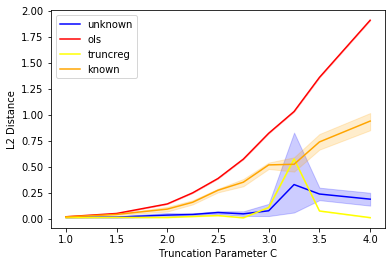

In [124]:
# plot results for regression parameter MSE
sns.lineplot(data=results, x='c', y='unknown_param_mse', label='unknown', color='blue')
sns.lineplot(data=results, x='c', y='ols_param_mse', label='ols', color='red')
sns.lineplot(data=results, x='c', y='trunc_reg_param_mse', label='truncreg', color='yellow')
ax = sns.lineplot(data=results, x='c', y='known_param_mse', label='known', color='orange')
ax.set(xlabel='Truncation Parameter C', ylabel='L2 Distance')
plt.show()

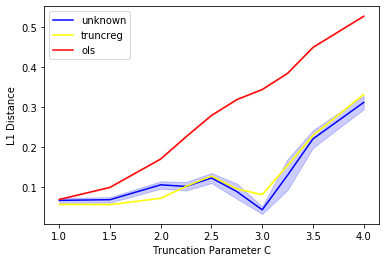

In [125]:
# plot results for regression noise variance MSE
sns.lineplot(data=results, x='c', y='unknown_var_l1', label='unknown', color="blue")
sns.lineplot(data=results, x='c', y='trunc_reg_var_l1', label='truncreg', color='yellow')
ax = sns.lineplot(data=results, x='c', y='ols_var_l1', label='ols', color="red")
ax.set(xlabel='Truncation Parameter C', ylabel='L1 Distance')
# ax.set(ylim=(0, .05))
plt.show()

In [127]:
results[results['c'] == 3.0]['unknown_param_mse']

6    0.015020
6    0.005294
6    0.279871
6    0.008269
6    0.154836
6    0.201317
6    0.013565
6    0.003321
6    0.048903
6    0.017071
Name: unknown_param_mse, dtype: float64